In [ ]:
# imports

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

import copy

from IPython.utils import io

from keras.datasets import cifar10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Formatting Data
Downloading, formatting, and normalizing data

In [ ]:
def normalize(data):
  return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [ ]:
(train_X, train_y), (test_X, test_y) = cifar10.load_data()

# Normalizing
train_X, test_X = train_X/255, test_X/255
train_X, test_X = normalize(train_X), normalize(test_X)

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
print('Training data shape: ' + str(train_X.shape))
print('Test data shape:  '  + str(test_X.shape))

Training data shape: (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


In [ ]:
print('Mean:', np.mean(train_X))
print('Variance:', np.std(train_X))

Mean: -5.1237583065244506e-14
Variance: 1.000000000000001


In [ ]:
X_train, y_train = [], []

# labels 0-9
for i in range(10):
  # all data of label i
  i_samples = np.where(train_y == i)[0]

  # get 1000 samples from each class
  indices = i_samples[np.random.randint(0, len(i_samples), size=1000)]

  X_train.extend([img.T for img in train_X[indices]])
  y_train.extend(train_y[indices])

X_train = np.array(X_train)
y_train = np.array(y_train)

print('Training data shape: ' + str(X_train.shape))
print('Training labels shape:  '  + str(y_train.shape))

Training data shape: (10000, 3, 32, 32)
Training labels shape:  (10000, 1)


In [ ]:
# transpose images
X_test = np.array([img.T for img in test_X])

print('Test data shape: ' + str(X_test.shape))
print('Test labels shape:  '  + str(test_y.shape))

Test data shape: (10000, 3, 32, 32)
Test labels shape:  (10000, 1)


# 1. Training ResNet

In [ ]:
def check_accuracy(test_loader: DataLoader, model: torch.nn.Module, device):
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.float().to(device=device)
            labels = labels.float().to(device=device)

            predictions = model(data)

            num_correct += (predictions.max(1)[1] == labels.flatten()).sum()
            total += labels.size(0)

        print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

        return float(num_correct)/float(total)*100

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# adjusting the output
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

model.eval()
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(y_train))

dataset = TensorDataset(inputs, labels)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
inputs = Variable(torch.from_numpy(X_test))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
loss_history = []
training_accuracy = []

for epoch in range(100):

    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      x_batch, y_batch = x_batch.to(device), y_batch.to(device)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
      optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = model(x_batch.float())

      # get loss for the predicted output
      loss = criterion(outputs, y_batch.flatten().long())

      loss_history.append(loss.item())

      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()

    with io.capture_output() as captured:
      training_accuracy.append(check_accuracy(test_dataloader, model, device))

    if (epoch + 1) % 20 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

epoch 20, loss 0.0009321107063442469
epoch 40, loss 0.01804538443684578
epoch 60, loss 0.47534242272377014
epoch 80, loss 0.01203132327646017
epoch 100, loss 0.0030325939878821373


In [ ]:
# Final Test Accuracy
check_accuracy(test_dataloader, model, device)

Test Accuracy of the model: 53.98


53.98

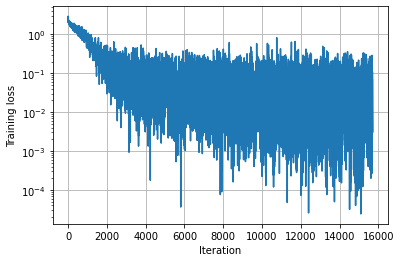

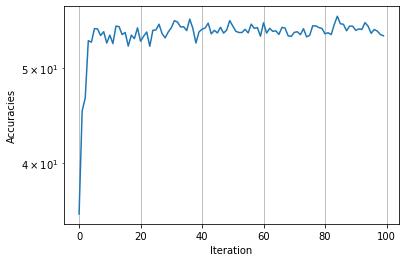

In [ ]:
# Training Loss
plt.figure()
plt.semilogy(loss_history)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss') 
plt.show()

# Training Accuracies
plt.figure()
plt.semilogy(training_accuracy)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracies') 
plt.show()

As we can see above, the model did improve in accuracy over time. Although, it only improved up to around 55%, which leaves much to be desired. This may be due to the relatively short amount of training time (100 epochs), and no data augmentations. We also used less data and did not tune any of the hyperparameters, so a low performance is expected. 

# 2. Mixup Augmentation

https://sparrow.dev/pytorch-one-hot-encoding/

In [ ]:
def one_hot(labels, num_classes):
  return F.one_hot(labels.to(torch.int64), num_classes).squeeze(1)

In [ ]:
# Training dataloaders
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(y_train))

dataset = TensorDataset(inputs, labels)
train_dataloader_1 = DataLoader(dataset, batch_size=64, shuffle=True)

dataset = TensorDataset(inputs, labels)
train_dataloader_2 = DataLoader(dataset, batch_size=64, shuffle=True)

# Testing dataloader
inputs = Variable(torch.from_numpy(X_test))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training ResNet with Mixup Augmentation alpha=0.2
epoch 20, loss 2.0072429180145264
epoch 40, loss 0.027295170351862907
epoch 60, loss 1.585777759552002
epoch 80, loss 0.014707357622683048
epoch 100, loss 0.15667416155338287
Test Accuracy of the model: 57.06

Final Test Accuracy with alpha=0.2: 57.06


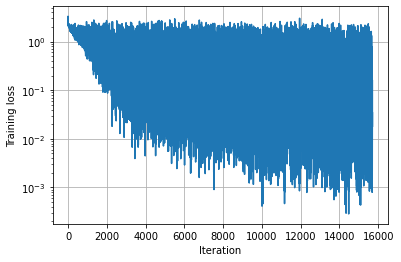

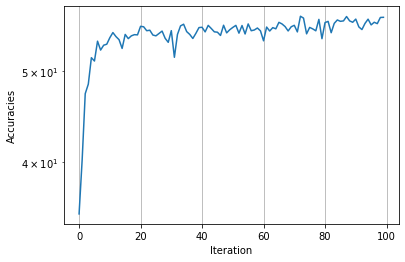

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training ResNet with Mixup Augmentation alpha=0.4
epoch 20, loss 1.9616641998291016
epoch 40, loss 0.1529574692249298
epoch 60, loss 0.021982306614518166
epoch 80, loss 0.3605612516403198
epoch 100, loss 0.002596107078716159
Test Accuracy of the model: 56.60

Final Test Accuracy with alpha=0.4: 56.599999999999994


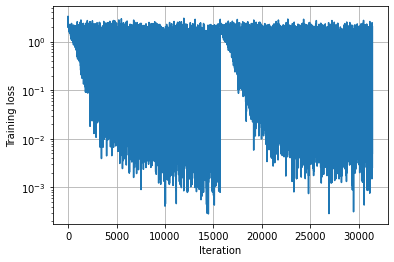

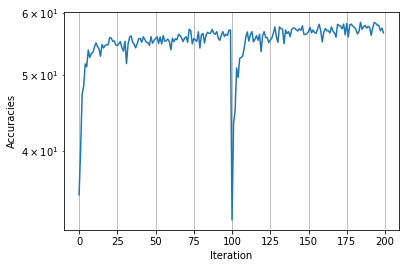

In [ ]:
loss_history = []
training_accuracy = []

for alpha in [0.2, 0.4]:

  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
  # adjusting the output
  model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

  model.eval()
  model = model.to(device)

  # Loss Function & Optimizer
  criterion = torch.nn.CrossEntropyLoss() 
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  print(f'Training ResNet with Mixup Augmentation alpha={alpha}')

  for epoch in range(100):

      for id_batch, ((x_1, y_1), (x_2, y_2)) in enumerate(zip(train_dataloader_1, train_dataloader_2)):

        x_1, y_1 = x_1.to(device), y_1.to(device)
        x_2, y_2 = x_2.to(device), y_2.to(device)

        y1_onehot, y2_onehot = one_hot(y_1, 10), one_hot(y_2, 10)

        # mixup augmentation
        lambd = np.random.beta(alpha, alpha)
        x_batch = Variable(lambd * x_1 + (1. - lambd) * x_2)
        y_batch = Variable(lambd * y1_onehot + (1. - lambd) * y2_onehot)

        # reverse onehot encoding
        y_batch = y_batch.argmax(-1)

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(x_batch.float())

        # get loss for the predicted output
        loss = criterion(outputs, y_batch.flatten().long())

        loss_history.append(loss.item())

        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

      with io.capture_output() as captured:
        training_accuracy.append(check_accuracy(test_dataloader, model, device))

      if (epoch + 1) % 20 == 0:
        print('epoch {}, loss {}'.format(epoch + 1, loss.item()))
    
  # Final Test Accuracy
  acc = check_accuracy(test_dataloader, model, device)
  print(f'\nFinal Test Accuracy with alpha={alpha}: {acc}')
  
  # Training Loss
  plt.figure()
  plt.semilogy(loss_history)    
  plt.grid()
  plt.xlabel('Iteration')
  plt.ylabel('Training loss') 
  plt.show()

  # Training Accuracies
  plt.figure()
  plt.semilogy(training_accuracy)    
  plt.grid()
  plt.xlabel('Iteration')
  plt.ylabel('Accuracies') 
  plt.show()

Augmenting the data with mixup definitely improve the accuracy of the model. The accuracy of the model increased by around 5%, although the overall acurracy is still relatively low. Simply in terms of data augmentation however, it can be said the mixup improved the performance of the model. 

Once again we can see that the model improved in accuracy over time, and loss decreased over time. However, interestingly, there was an iteration in which loss spiked up and accuracy dropped down. I am not sure what the cause of this was however. 

An alpha of 0.2 seemed to be better than an alpha of 0.4, although not by much. An alpha of 0.2 did seem to be more stable, however.

# 3. Cutout Augmentation

In [ ]:
def get_cutout(img, k):
  c, h, w = img.size(0), img.size(1), img.size(2)

  # cutout will be applied on top of image
  cutout = np.ones((h, w)).astype(np.float32)

  # random pixels in the image
  y = np.random.randint(h)
  x = np.random.randint(w)

  # get corners of cutout
  y1 = np.clip(y - k // 2, 0, h)
  y2 = np.clip(y + k // 2, 0, h)
  x1 = np.clip(x - k // 2, 0, w)
  x2 = np.clip(x + k // 2, 0, w)

  # cutout segment
  cutout[y1:y2, x1:x2] = 0

  cutout = torch.from_numpy(cutout).to(device)
  cutout = cutout.expand_as(img)

  # apply cutout to image
  return  img * cutout

def apply_cutout(x, k=16):
  upd_x = copy.deepcopy(x).to(device)
  for i, img in enumerate(upd_x):
    flip = np.random.uniform(0,1)

    if flip >= 0.5:
      upd_x[i] = get_cutout(img, k)
  
  return upd_x

### Testing Cutout Function
Testing our cutout function with a random image from the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


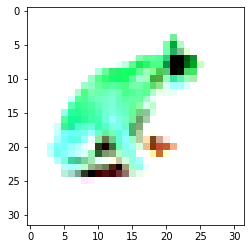

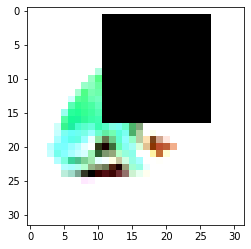

In [ ]:
plt.figure()
index = np.random.randint(0, len(X_train))
plt.imshow(X_train[index].T)
plt.figure()
plt.imshow(get_cutout(torch.tensor(X_train[index]),k=16).numpy().T)
plt.show()

In [ ]:
## Training dataloaders
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(y_train))

dataset = TensorDataset(inputs, labels)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Testing dataloader
inputs = Variable(torch.from_numpy(X_test))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# adjusting the output
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

model.eval()
model = model.to(device)

# Loss Function & Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
loss_history = []
epoch_loss = []
training_accuracy = []

for epoch in range(100):

    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      x_batch, y_batch = x_batch.to(device), y_batch.to(device)

      # cutout augmentation
      cutout_x = apply_cutout(x_batch, k=16)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
      optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = model(cutout_x.float())

      # get loss for the predicted output
      loss = criterion(outputs, y_batch.flatten().long())

      loss_history.append(loss.item())

      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()

    epoch_loss.append(loss.item())

    with io.capture_output() as captured:
      training_accuracy.append(check_accuracy(test_dataloader, model, device))

    if (epoch + 1) % 20 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

epoch 20, loss 0.04512506350874901
epoch 40, loss 0.07363907992839813
epoch 60, loss 0.14321237802505493
epoch 80, loss 0.001955824438482523
epoch 100, loss 0.045366719365119934


Test Accuracy of the model: 57.68


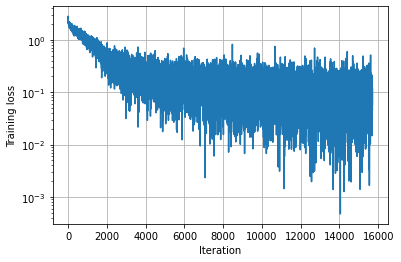

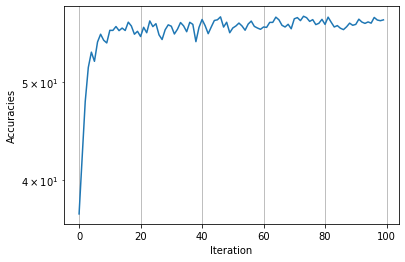

In [ ]:
# Final Test Accuracy
acc = check_accuracy(test_dataloader, model, device)

# Training Loss
plt.figure()
plt.semilogy(loss_history)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss') 
plt.show()

# Training Accuracies
plt.figure()
plt.semilogy(training_accuracy)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracies') 
plt.show()

Cutout Augmentation provided the highest accuracy so far. There was only a percent or two increase compared to mixup augmentation, however it could be more substantial if any hyperparameters were tuned. We used a set k value to create the cutout, it is possible that this value could be finetuned as well.

# 4. Standard Augmentation

https://numpy.org/doc/stable/reference/generated/numpy.roll.html

In [ ]:
# black out the shifted parts 
def blackout(img, axis, k):
  if axis == 1:
    if k < 0:     
      img[:, k:, :] = 0
    else:     
      img[:, :k, :] = 0
  elif axis == 2:
    if k < 0: 
      img[:, :, k:] = 0 
    else:
      img[:, :, :k] = 0
  
  return img

def shift_image(image, axis, k):
  img = copy.deepcopy(image)
  height, width = img.shape[1], img.shape[2]

  # shift image
  rolled = np.roll(img, k, axis=[axis])

  return blackout(rolled, axis, k)

## Testing image shift function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8791
k1: -8
k2: -10


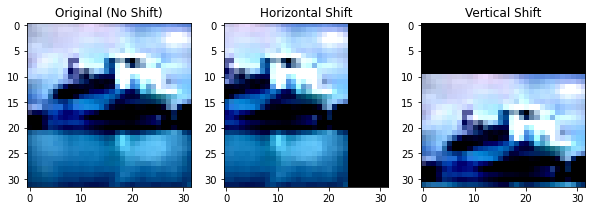

In [ ]:
plt.figure(figsize=(10, 10))

index = np.random.randint(0, len(X_train))
print(index)

k1, k2 = np.random.randint(-10, 10, 2)
print(f'k1: {k1}\nk2: {k2}')

img = X_train[index]
plt.subplot(1, 3, 1)
plt.title('Original (No Shift)')
plt.imshow(img.T)

# shift horizontally
plt.subplot(1, 3, 2)
plt.title('Horizontal Shift')
plt.imshow(shift_image(img, 1, k1).T)

# shift vertically
plt.subplot(1, 3, 3)
plt.title('Vertical Shift')
plt.imshow(shift_image(img, 2, -1 * k2).T)

## Testing horizontal flip

https://numpy.org/doc/stable/reference/generated/numpy.fliplr.html#numpy.fliplr

In [ ]:
def flip_image(img):
  return np.fliplr(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8307


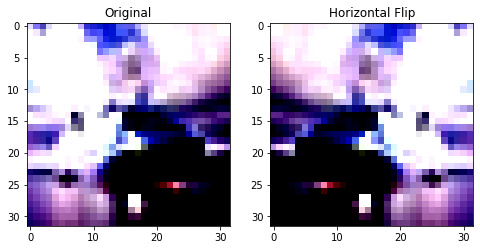

In [ ]:
plt.figure(figsize=(8, 8))

index = np.random.randint(0, len(X_train))
print(index)

img = X_train[index]
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img.T)

# flip horizontally
plt.subplot(1, 2, 2)
plt.title('Horizontal Flip')
plt.imshow(flip_image(img).T)

## Applying Standard Augmentation

In [ ]:
# Training dataloaders
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(y_train))

dataset = TensorDataset(inputs, labels)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Testing dataloader
inputs = Variable(torch.from_numpy(X_test))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# adjusting the output
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

model.eval()
model = model.to(device)

# Loss Function & Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
def standard_aug(x):
  upd_x = copy.deepcopy(x).to(device)

  for i, img in enumerate(upd_x):

    shifted_img = copy.deepcopy(img.cpu().numpy())
    k1, k2 = np.random.randint(-4, 4, 2)

    # shift horizontally
    shifted_img = shift_image(shifted_img, 1, k1)
    # shift vertically
    shifted_img = shift_image(shifted_img, 2, -1 * k2)

    flip = np.random.uniform(0,1)
    if flip >= 0.5:
      shifted_img = flip_image(shifted_img).copy()

    upd_x[i] = torch.from_numpy(shifted_img)
  
  return upd_x
  

In [ ]:
loss_history = []
epoch_loss = []
training_accuracy = []

for epoch in range(100):

    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      x_batch, y_batch = x_batch.to(device), y_batch.to(device)

      # standard augmentation
      standard_x = standard_aug(x_batch)   

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
      optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = model(standard_x.float())

      # get loss for the predicted output
      loss = criterion(outputs, y_batch.flatten().long())

      loss_history.append(loss.item())

      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()

    epoch_loss.append(loss.item())

    with io.capture_output() as captured:
      training_accuracy.append(check_accuracy(test_dataloader, model, device))

    if (epoch + 1) % 20 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

epoch 20, loss 0.9550192356109619
epoch 40, loss 0.2166956663131714
epoch 60, loss 0.21760043501853943
epoch 80, loss 0.4680253565311432
epoch 100, loss 0.07542184740304947


Test Accuracy of the model: 67.38


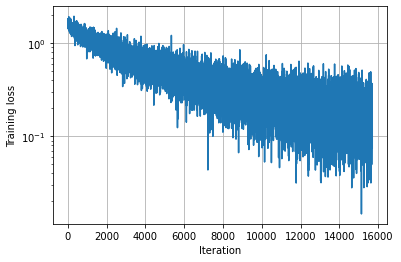

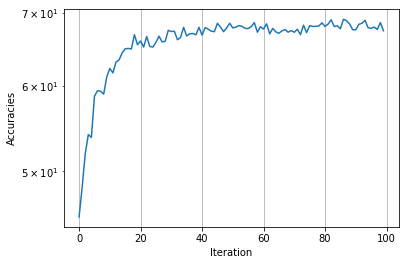

In [ ]:
# Final Test Accuracy
acc = check_accuracy(test_dataloader, model, device)

# Training Loss
plt.figure()
plt.semilogy(loss_history)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss') 
plt.show()

# Training Accuracies
plt.figure()
plt.semilogy(training_accuracy)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracies') 
plt.show()

Standard augmentation definitely resulted in a substantial improvement from the original model, about 14% increase in accuracy. It is interesting how cutout did not provide as large of a boost in performance even though the concept is somewhat reminiscent to standard augmentation.

# 5. Combine Augmentations

For mixup augmentation, we will be using alpha = 0.2 since it performed better in the earlier test.

In [ ]:
# Training dataloaders
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(y_train))

dataset = TensorDataset(inputs, labels)
train_dataloader_1 = DataLoader(dataset, batch_size=64, shuffle=True)

dataset = TensorDataset(inputs, labels)
train_dataloader_2 = DataLoader(dataset, batch_size=64, shuffle=True)

# Testing dataloader
inputs = Variable(torch.from_numpy(X_test))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# adjusting the output
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

model.eval()
model = model.to(device)

# Loss Function & Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training ResNet with All Augmentation alpha=0.2
epoch 20, loss 1.1750487089157104
epoch 40, loss 0.2997976541519165
epoch 60, loss 0.577021062374115
epoch 80, loss 0.2517162561416626
epoch 100, loss 0.2413979321718216
Test Accuracy of the model: 69.47

Final Test Accuracy with alpha=0.4: 69.47


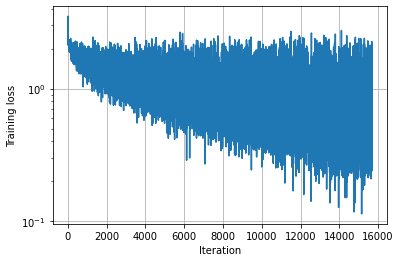

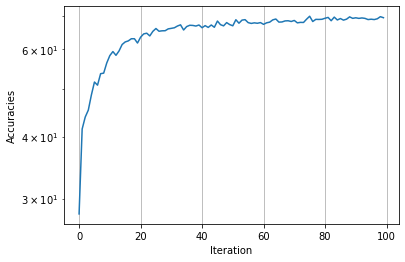

In [ ]:
loss_history = []
training_accuracy = []

print(f'Training ResNet with All Augmentation alpha={0.2}')

for epoch in range(100):

    for id_batch, ((x_1, y_1), (x_2, y_2)) in enumerate(zip(train_dataloader_1, train_dataloader_2)):

      x_1, y_1 = x_1.to(device), y_1.to(device)
      x_2, y_2 = x_2.to(device), y_2.to(device)

      y1_onehot, y2_onehot = one_hot(y_1, 10), one_hot(y_2, 10)

      ## combine augmentations

      # standard augmentation
      std_x1, std_x2 = standard_aug(x_1), standard_aug(x_2)
      # cutout augmentation
      upd_x1, upd_x2 = apply_cutout(std_x1), apply_cutout(std_x2)

      # mixup augmentation (alpha = 0.2)
      lambd = np.random.beta(0.2, 0.2)
      x_batch = Variable(lambd * upd_x1 + (1. - lambd) * upd_x2)
      y_batch = Variable(lambd * y1_onehot + (1. - lambd) * y2_onehot)

      # reverse onehot encoding
      y_batch = y_batch.argmax(-1)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
      optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = model(x_batch.float())

      # get loss for the predicted output
      loss = criterion(outputs, y_batch.flatten().long())

      loss_history.append(loss.item())

      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()

    with io.capture_output() as captured:
      training_accuracy.append(check_accuracy(test_dataloader, model, device))

    if (epoch + 1) % 20 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))
  
# Final Test Accuracy
acc = check_accuracy(test_dataloader, model, device)
print(f'\nFinal Test Accuracy with alpha={alpha}: {acc}')

# Training Loss
plt.figure()
plt.semilogy(loss_history)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss') 
plt.show()

# Training Accuracies
plt.figure()
plt.semilogy(training_accuracy)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracies') 
plt.show()

The performance of the model is the highest with all the augmentations, which was to be expected. It's only somewhat higher than with just the standard augmentation, so it seems that standard augmentation is doing a majority of the heavy lifting.


# 6. Comments

To recap, we had the following accuracies:


*   No Augmentations: **53.98%**
*   Mixup Augmentation: 

  *   Alpha of 0.2: **57.06%**
  *   Alpha of 0.4: **56.60%**

*   Cutout Augmentation: **57.68%**
*   Standard Augmentation: **67.38%**
*   All Augmentations: **69.47%**

Overall, we saw almost a 16% improvement in accuracy with the augmentations, when compared to the original model trained on data with no augmentations.

#### **How does data augmentation affect test accuracy?**

Data augmentation improved the test accuracy of the ResNet model in all cases in which we applied some augmentation, when compared to the original test accuracy based on data without augmentations. 

#### **How does data augmentation affect training accuracy?**

The training accuracy of the models seems to converge faster with data augmentations than without. However, this would require more testing to prove. Just purely based on the results above it seems to be the case, however. 

#### **Is test accuracy higher?**

As described above, the accuracy of the model increase with each subsequent augmentation, finally resulting in almost a 16% improvement.

#### **Does training loss converge faster?**

It is difficult to say exactly, but based on the results above it seems that data augmentation does have a positive affect on time taken to train the model. This would need to be tested further however.